In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy.spatial
import functools

%matplotlib inline

In [2]:
### Kernel function generators
def linear_kernel(W, X):
    """
    Computes the linear kernel between two sets of vectors.
    Args:
        W, X - two matrices of dimensions n1xd and n2xd
    Returns:
        matrix of size n1xn2, with w_i^T x_j in position i,j
    """
    return np.dot(W,np.transpose(X))

def polynomial_kernel(W, X, offset, degree):
    """
    Computes the inhomogeneous polynomial kernel between two sets of vectors
    Args:
        W, X - two matrices of dimensions n1xd and n2xd
        offset, degree - two parameters for the kernel
    Returns:
        matrix of size n1xn2, with (offset + <w_i,x_j>)^degree in position i,j
    """
    return (offset + linear_kernel(W,X)) ** degree

            
def RBF_kernel(W,X,sigma):
    """
    Computes the RBF kernel between two sets of vectors   
    Args:
        W, X - two matrices of dimensions n1xd and n2xd
        sigma - the bandwidth (i.e. standard deviation) for the RBF/Gaussian kernel
    Returns:
        matrix of size n1xn2, with exp(-||w_i-x_j||^2/(2 sigma^2)) in position i,j
    """
    V = scipy.spatial.distance.cdist(W,X,'sqeuclidean')
    return np.exp((-V)/(2*sigma**2))




In [3]:
prototypes = np.array([-4,-1,0,2]).reshape(-1,1)
linear_kernel(prototypes, prototypes)

array([[16,  4,  0, -8],
       [ 4,  1,  0, -2],
       [ 0,  0,  0,  0],
       [-8, -2,  0,  4]])

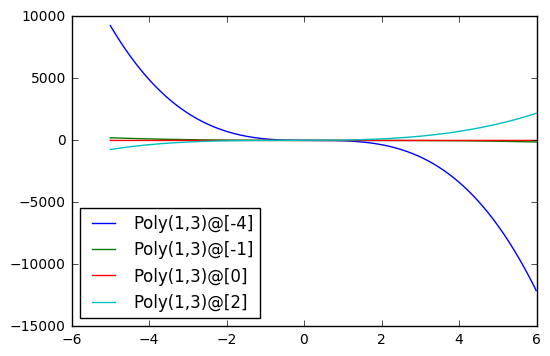

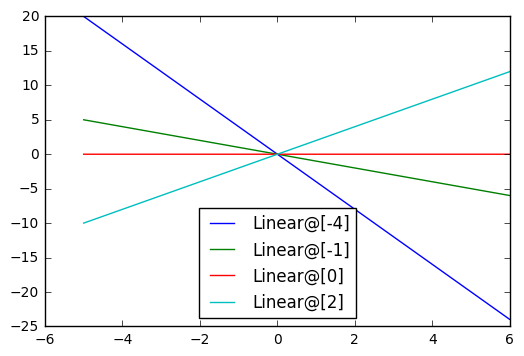

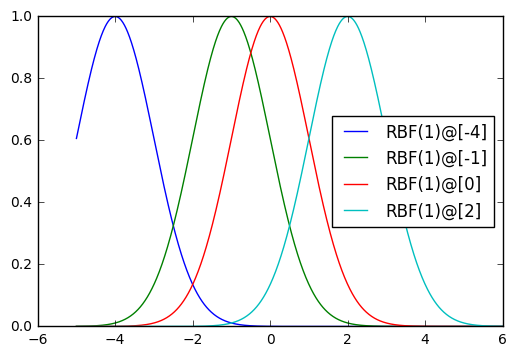

In [4]:
plot_step = .01
xpts = np.arange(-5.0, 6, plot_step).reshape(-1,1)
prototypes = np.array([-4,-1,0,2]).reshape(-1,1)


offset =1; degree=3; 
y = polynomial_kernel(prototypes,xpts, offset=offset, degree=degree) 
for i in range(len(prototypes)):
    label = "Poly("+str(offset)+","+str(degree)+")@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.show() 

y = linear_kernel(prototypes, xpts) 
for i in range(len(prototypes)):
    label = "Linear@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.show() 

sigma = 1
y = RBF_kernel(prototypes, xpts, sigma) 
for i in range(len(prototypes)):
    label = "RBF("+str(sigma)+")@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.show() 
 

In [5]:
class Kernel_Machine(object):
    def __init__(self, kernel, prototype_points, weights):
        """
        Args:
            kernel(W,X) - a function return the cross-kernel matrix between rows of W and rows of X for kernel k
            prototype_points - an Rxd matrix with rows mu_1,...,mu_R
            weights - a vector of length R
        """

        self.kernel = kernel
        self.prototype_points = prototype_points
        self.weights = weights
        
    def predict(self, X):
        """
        Evaluates the kernel machine on the points given by the rows of X
        Args:
            X - an nxd matrix with inputs x_1,...,x_n in the rows
        Returns:
            Vector of kernel machine evaluations on the n points in X.  Specifically, jth entry of return vector is
                Sum_{i=1}^R w_i k(x_j, mu_i)
        """
        cross_kernel_matrix = self.kernel(X, self.prototype_points)
        return np.dot(cross_kernel_matrix,self.weights)

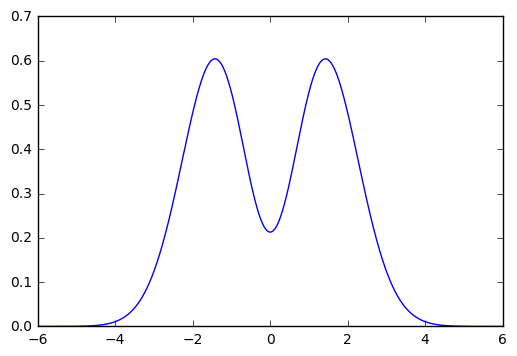

In [6]:
protos = np.array((-1,0,1)).reshape(-1,1)
weights = np.array((1,-1,1)).reshape(-1,1)
k = functools.partial(RBF_kernel, sigma=1)
f = Kernel_Machine(k, protos, weights)  

plot_step = .01
xpts = np.arange(-6.0 , 6, plot_step).reshape(-1,1)
plt.plot(xpts, f.predict(xpts))
plt.show() 

Load train & test data; Convert to column vectors so it generalizes well to data in higher dimensions.

In [7]:
data_train,data_test = np.loadtxt("krr-train.txt"),np.loadtxt("krr-test.txt")
x_train, y_train = data_train[:,0].reshape(-1,1),data_train[:,1].reshape(-1,1)
x_test, y_test = data_test[:,0].reshape(-1,1),data_test[:,1].reshape(-1,1)

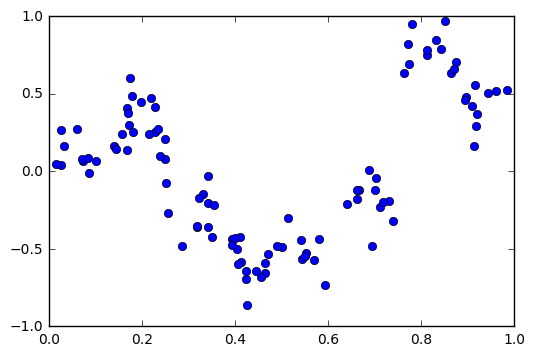

In [8]:
plt.plot(x_train,y_train,'o')
plt.show()

In [9]:
def train_kernel_ridge_regression(X, y, kernel, l2reg):
    n = len(y)
    I = np.identity(n)
    K = kernel(X,X)
    # Note: While below is the literal version, the lstsq is equivalent and may do better with no regularization
    #alpha = np.dot(np.linalg.inv(l2reg * I + K), y) 
    alpha = np.linalg.lstsq((l2reg * I + K), y)[0]
    return Kernel_Machine(kernel, X, alpha)

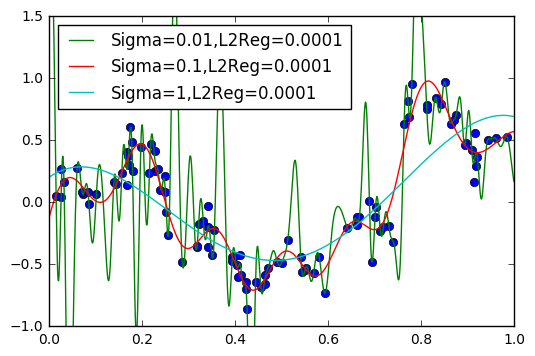

In [10]:
plot_step = .001
xpts = np.arange(0 , 1, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
l2reg = 0.0001
for sigma in [.01,.1,1]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
    label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.5)
plt.show()

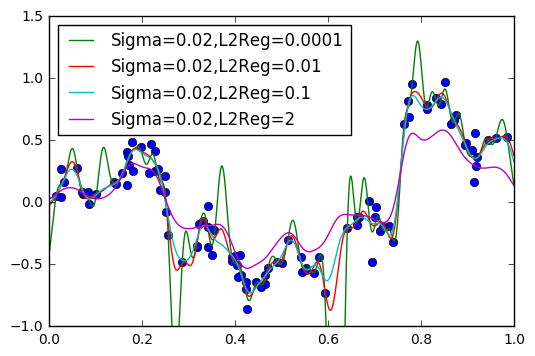

In [11]:
plot_step = .001
xpts = np.arange(0 , 1, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
sigma= .02
for l2reg in [.0001,.01,.1,2]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
    label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.5)
plt.show()

In [12]:
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin

class KernelRidgeRegression(BaseEstimator, RegressorMixin):  
    """sklearn wrapper for our kernel ridge regression"""
     
    def __init__(self, kernel="RBF", sigma=1, degree=2, offset=1, l2reg=1):        
        self.kernel = kernel
        self.sigma = sigma
        self.degree = degree
        self.offset = offset
        self.l2reg = l2reg 

    def fit(self, X, y=None):
        """
        This should fit classifier. All the "work" should be done here.
        """
        if (self.kernel == "linear"):
            self.k = linear_kernel
        elif (self.kernel == "RBF"):
            self.k = functools.partial(RBF_kernel, sigma=self.sigma)
        elif (self.kernel == "polynomial"):
            self.k = functools.partial(polynomial_kernel, offset=self.offset, degree=self.degree)
        else:
            raise ValueError('Unrecognized kernel type requested.')
        
        self.kernel_machine_ = train_kernel_ridge_regression(X, y, self.k, self.l2reg)

        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "kernel_machine_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        return(self.kernel_machine_.predict(X))

    def score(self, X, y=None):
        # get the average square error
        return((self.predict(X)-y).mean()) 

In [13]:
from sklearn.model_selection import GridSearchCV,PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error,make_scorer
import pandas as pd
    
test_fold = [-1]*len(x_train) + [0]*len(x_test)   #0 corresponds to test, -1 to train
predefined_split = PredefinedSplit(test_fold=test_fold)

In [14]:
param_grid = [{'kernel': ['RBF'],'sigma':np.arange(.05,.07,.001), 'l2reg': np.exp2(-np.arange(1,5,.2))},
              {'kernel':['polynomial'],'offset':[0,0.5,1], 'degree':[2,3,4],'l2reg':[10,1, .1, .01] },
              {'kernel':['linear'],'l2reg': [10,1, .1, .01]}]
param_grid = [{'kernel': ['RBF'],'sigma':[.065], 'l2reg': [.1] },
              {'kernel':['polynomial'],'offset':np.arange(-30,-10,2), 'degree':np.arange(10,20,1),'l2reg':[.0001,.00001,.001] },
              {'kernel':['linear'],'l2reg': [0]}]
kernel_ridge_regression_estimator = KernelRidgeRegression()
grid = GridSearchCV(kernel_ridge_regression_estimator, 
                    param_grid,
                    cv = predefined_split,
                    scoring = make_scorer(mean_squared_error,greater_is_better = False)
                  # n_jobs = -1
                   )
grid.fit(np.vstack((x_train,x_test)),np.vstack((y_train,y_test))) 

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
       error_score='raise',
       estimator=KernelRidgeRegression(degree=2, kernel='RBF', l2reg=1, offset=1, sigma=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'l2reg': [0.1], 'sigma': [0.065], 'kernel': ['RBF']}, {'l2reg': [0.0001, 1e-05, 0.001], 'degree': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), 'offset': array([-30, -28, -26, -24, -22, -20, -18, -16, -14, -12]), 'kernel': ['polynomial']}, {'l2reg': [0], 'kernel': ['linear']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(mean_squared_error, greater_is_better=False),
       verbose=0)

In [15]:
pd.set_option('display.max_rows', 20)
df = pd.DataFrame(grid.cv_results_)
# Flip sign of score back, because GridSearchCV likes to maximize,
# so it flips the sign of the score if "greater_is_better=FALSE"
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
cols_to_keep = ["param_degree", "param_kernel","param_l2reg" ,"param_offset","param_sigma",
        "mean_test_score","mean_train_score"]
df_toshow = df[cols_to_keep].fillna('-')
df_toshow.sort_values(by=["mean_test_score"])



,param_degree,param_kernel,param_l2reg,param_offset,param_sigma,mean_test_score,mean_train_score
0,-,RBF,0.10000,-,0.065,0.013815,0.014412
128,14,polynomial,0.00010,-16,-,0.026171,0.032552
138,14,polynomial,0.00001,-16,-,0.026171,0.032552
148,14,polynomial,0.00100,-16,-,0.026171,0.032552
99,13,polynomial,0.00010,-14,-,0.027798,0.032739
109,13,polynomial,0.00001,-14,-,0.027798,0.032739
119,13,polynomial,0.00100,-14,-,0.027798,0.032739
90,12,polynomial,0.00100,-12,-,0.028043,0.031891
290,19,polynomial,0.00001,-12,-,0.028325,0.028158
280,19,polynomial,0.00010,-12,-,0.028325,0.028158


In [16]:
import qgrid
#pd.set_option('display.max_rows', 20)
#qgrid.nbinstall(overwrite=True)  # copies javascript dependencies to your /nbextensions folderd_toshow = df[show].fillna('-')

In [17]:
qgrid.show_grid(df_toshow)

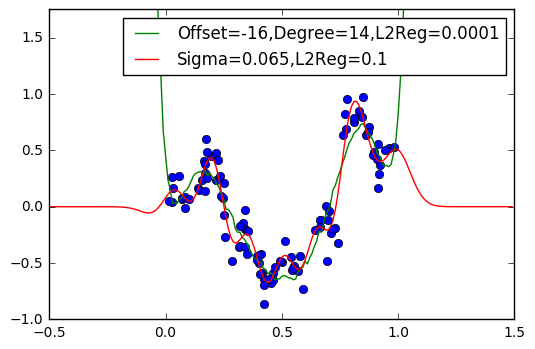

In [18]:
## Plot the best polynomial and RBF fits
plot_step = .01
xpts = np.arange(-.5 , 1.5, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
#Plot best polynomial fit
offset= -16
degree = 14
l2reg = .0001
k = functools.partial(polynomial_kernel, offset=offset, degree=degree)
f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
label = "Offset="+str(offset)+",Degree="+str(degree)+",L2Reg="+str(l2reg)
plt.plot(xpts, f.predict(xpts), label=label)
#Plot best RBF fit
sigma = .065
l2reg= .1
k = functools.partial(RBF_kernel, sigma=sigma)
f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.75)
plt.show()

Now the SVM problem

In [19]:
#load the training and test sets
data_train,data_test = np.loadtxt("svm-train.txt"),np.loadtxt("svm-test.txt")
x_train, y_train = data_train[:,0:2], data_train[:,2].reshape(-1,1)
x_test, y_test = data_test[:,0:2], data_test[:,2].reshape(-1,1)

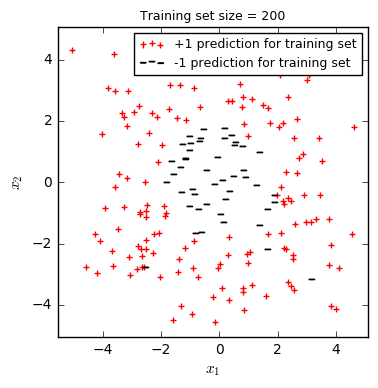

In [20]:
#determine predictions for the training set
yplus = np.ma.masked_where(y_train[:,0]<=0, y_train[:,0])
xplus = x_train[~np.array(yplus.mask)]
yminus = np.ma.masked_where(y_train[:,0]>0, y_train[:,0])
xminus = x_train[~np.array(yminus.mask)]

#plot the predictions for the training set
figsize = plt.figaspect(1)
f, (ax) = plt.subplots(1, 1, figsize=figsize) 

pluses = ax.scatter (xplus[:,0], xplus[:,1], marker='+', c='r', label = '+1 prediction for training set')
minuses = ax.scatter (xminus[:,0], xminus[:,1], marker=r'$-$', c='b', label = '-1 prediction for training set')

ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('Training set size = %s'% len(data_train), fontsize=9)  
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()

In [21]:
# train_soft_svm takes the numpy arrays containing 
# the measurements of x in R^{2 x d} and y in R^d, 
# the kernel, the maximum number of SGD steps T and 
# the regularization parameter Lambda. It returns 
# the corresponding Kernel_Machine  
def train_soft_svm(X, y, kernel, T, Lambda):
    
    # sgd_for_soft_svm implements the above-mentioned method from SSBD.
    # It takes the numpy arrays containing the measurements y in {-1,+1},
    # the kernel K in R^{d x d} the maximum number of steps T and 
    # the regularization parameter lambda. It returns the coefficients alpha_bar
    # of the solution w_bar represented as a linear combination  
    def sgd_for_soft_svm (y, K, T, Lambda): 
        sample_size = len(y)
        beta=[] 
        beta.append(np.zeros(sample_size))
        alpha = []
    
        for t in range(T):
            alpha_temp= (beta[t] / (Lambda*(t+1) ))
            i = np.random.randint(sample_size)
            beta_temp = beta[t]
            temp=0
            for j in range (sample_size): 
                temp = temp+ alpha_temp[j]* K[j,i]
            if ((y[i]*temp)<1):
                beta_temp[i]= beta_temp[i]+y[i]         
            beta.append(beta_temp)
            alpha.append(alpha_temp)
        alpha_bar = 1/T* np.sum(alpha, axis=0)                  
        return alpha_bar
    
    K = kernel(X,X)
    alpha= sgd_for_soft_svm (y, K, T, Lambda)
    return Kernel_Machine(kernel, X, alpha)

In [22]:
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin

class KernelSoftSVM(BaseEstimator, RegressorMixin):  
    """sklearn wrapper for our kernel ridge regression"""
     
    def __init__(self, kernel="linear", sigma=1, degree=2, offset=1, T = 1000, l2reg=0.2):        
        self.kernel = kernel
        self.sigma = sigma
        self.degree = degree
        self.offset = offset
        self.l2reg = l2reg 
        self.T = T

    def fit(self, X, y=None):
        """
        This should fit classifier. All the "work" should be done here.
        """
        if (self.kernel == "linear"):
            self.k = linear_kernel
        elif (self.kernel == "RBF"):
            self.k = functools.partial(RBF_kernel, sigma=self.sigma)
        elif (self.kernel == "polynomial"):
            self.k = functools.partial(polynomial_kernel, offset=self.offset, degree=self.degree)
        else:
            raise ValueError('Unrecognized kernel type requested.')
        
        self.kernel_machine_ = train_soft_svm(X, y, self.k, self.T, self.l2reg)

        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "kernel_machine_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        return(self.kernel_machine_.predict(X))
        
    def score(self, X, y=None):
        # get the average square error
        return((self.predict(X)-y).mean()) 

In [23]:
from sklearn.model_selection import GridSearchCV,PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error,make_scorer
import pandas as pd
    
test_fold = [-1]*len(x_train) + [0]*len(x_test)   #0 corresponds to test, -1 to train
predefined_split = PredefinedSplit(test_fold=test_fold)

In [24]:
param_grid = [{'kernel': ['RBF'],'sigma':[.1,1,10], 'l2reg': np.exp2(-np.arange(-5,5,1))},
              {'kernel':['polynomial'],'offset':[-1,0,1], 'degree':[2,3,4],'l2reg':[10, .1, .01] },
              {'kernel':['linear'],'l2reg': [10,1,.01]}]
kernel_soft_SVM_estimator = KernelSoftSVM()
grid = GridSearchCV(kernel_soft_SVM_estimator, 
                    param_grid,
                    cv = predefined_split,
                    scoring = make_scorer(mean_squared_error,greater_is_better = False)
                  # n_jobs = -1  #should allow parallelism, but crashes Python on my machine
                   )
grid.fit(np.vstack((x_train,x_test)),np.vstack((y_train,y_test))) 

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
       error_score='raise',
       estimator=KernelSoftSVM(T=1000, degree=2, kernel='linear', l2reg=0.2, offset=1, sigma=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'l2reg': array([ 32.    ,  16.    ,   8.    ,   4.    ,   2.    ,   1.    ,
         0.5   ,   0.25  ,   0.125 ,   0.0625]), 'sigma': [0.1, 1, 10], 'kernel': ['RBF']}, {'l2reg': [10, 0.1, 0.01], 'degree': [2, 3, 4], 'offset': [-1, 0, 1], 'kernel': ['polynomial']}, {'l2reg': [10, 1, 0.01], 'kernel': ['linear']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(mean_squared_error, greater_is_better=False),
       verbose=0)

In [25]:
pd.set_option('display.max_rows', 60)
df = pd.DataFrame(grid.cv_results_)
# Flip sign of score back, because GridSearchCV likes to maximize,
# so it flips the sign of the score if "greater_is_better=FALSE"
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
cols_to_keep = ["param_degree", "param_kernel","param_l2reg" ,"param_offset","param_sigma",
        "mean_test_score","mean_train_score"]
df_toshow = df[cols_to_keep].fillna('-')
df_toshow.sort_values(by=["mean_test_score"])

,param_degree,param_kernel,param_l2reg,param_offset,param_sigma,mean_test_score,mean_train_score
28,-,RBF,0.0625,-,1,5.331468e-01,4.817304e-01
25,-,RBF,0.1250,-,1,7.168267e-01,6.604197e-01
31,2,polynomial,10.0000,0,-,8.789665e-01,8.792912e-01
20,-,RBF,0.5000,-,10,8.987131e-01,9.908470e-01
30,2,polynomial,10.0000,-1,-,9.171551e-01,9.222335e-01
22,-,RBF,0.2500,-,1,9.186006e-01,8.772083e-01
26,-,RBF,0.1250,-,10,9.248402e-01,1.038445e+00
23,-,RBF,0.2500,-,10,9.257332e-01,1.036967e+00
17,-,RBF,1.0000,-,10,9.263552e-01,9.911031e-01
32,2,polynomial,10.0000,1,-,9.531023e-01,9.486786e-01


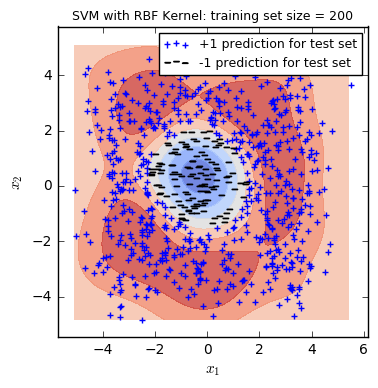

In [26]:
# Apply the SDG with the best fit kernel (RBF) to the test set
T = 1000       
Lambda = 0.0625
sigma=1
k = functools.partial(RBF_kernel, sigma=sigma)
f = train_soft_svm(x_train, y_train, k, T, Lambda)

#determine the decision regions for the predictions
x1_min = min(x_test[:,0])
x1_max= max(x_test[:,0])
x2_min = min(x_test[:,1])
x2_max= max(x_test[:,1])
h=0.1
xx, yy = np.meshgrid(np.arange(x1_min, x1_max, h),
                     np.arange(x2_min, x2_max, h))

Z = f.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

#determine the predictions for the test set
y_bar = f.predict (x_test) 
yplus = np.ma.masked_where(y_bar<=0, y_bar)
xplus = x_test[~np.array(yplus.mask)]
yminus = np.ma.masked_where(y_bar>0, y_bar)
xminus = x_test[~np.array(yminus.mask)]

#plot the learned boundary and the predictions for the test set
figsize = plt.figaspect(1)
f, (ax) = plt.subplots(1, 1, figsize=figsize) 
decision =ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
pluses = ax.scatter (xplus[:,0], xplus[:,1], marker='+', c='b', label = '+1 prediction for test set')
minuses = ax.scatter (xminus[:,0], xminus[:,1], marker=r'$-$', c='b', label = '-1 prediction for test set')
ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('SVM with RBF Kernel: training set size = %s'% len(data_train), fontsize=9)  
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()